### 1.) Importing necessary packages and functions

In [1]:
### see seismic_toolkit.py for full function documentation
from seismic_toolkit import *

### 2.) Loading the original .segy files

In [6]:
### define path to desired seismic reflectivity file
seismic_path = './Samson_cropped.segy'
### retrieve seismic reflectivitiy data and display metadata
reflectivity = load_segy(seismic_path)

C 1 SEGY OUTPUT FROM Petrel 2020.4 Wednesday, July 13 2022 10:25:20
C 2 Name: FULL-STACK Crop 1 Type: 3D seismic                                  C
3                                                                             C
4 First inline: 1380   Last inline: 2666                                      C
5 First xline:  1573   Last xline:  3121                                      C
6 CRS: ED50-UTM35 ("MENTOR:ED50-UTM35:European 1950 Based UTM, Zone 35 North, C
7 X min: 399444.30 max: 420120.44 delta: 20676.15                             C
8 Y min: 8018917.06 max: 8041869.78 delta: 22952.72                           C
9 Depth min: -6105.00 max: 5.00 delta: 6110.00
C10 Lat min: 72.14'40.9427"N max: 72.27'30.4499"N delta: 0.12'49.5072"
C11 Long min: 24.00'40.6206"E max: 24.39'6.1244"E delta: 0.38'25.5038"
C12 Trace min: -6100.00 max: 0.00 delta: 6100.00
C13 Seismic (template) min: ~-419819264.00 max: ~372658176.00 delta:
~792477440.C14 Amplitude (data) min: ~-419819264.00 max: ~3726581

In [7]:
### define path to desired FWI velocity data file
FWI_path = './FWI_velocity_crop.segy'
### retrieve FWI velocity data and display metadata
FWI = load_segy(FWI_path)

C 1 SEGY OUTPUT FROM Petrel 2020.4 Tuesday, August 09 2022 10:18:04
C 2 Name: CRAM-VEL-MODEL Crop 1 Type: 3D seismic                              C
3                                                                             C
4 First inline: 1380   Last inline: 2666                                      C
5 First xline:  1573   Last xline:  3121                                      C
6 CRS: ED50-UTM35 ("MENTOR:ED50-UTM35:European 1950 Based UTM, Zone 35 North, C
7 X min: 399444.30 max: 420120.56 delta: 20676.27                             C
8 Y min: 8018917.03 max: 8041869.74 delta: 22952.71                           C
9 Time min: -6105.00 max: 5.00 delta: 6110.00
C10 Lat min: 72.14'40.9418"N max: 72.27'30.4487"N delta: 0.12'49.5069"
C11 Long min: 24.00'40.6207"E max: 24.39'6.1370"E delta: 0.38'25.5162"
C12 Trace min: -6100.00 max: 0.00 delta: 6100.00
C13 Velocity (template) min: ~0.00 max: ~5720.70 delta: ~5720.70
C14 Amplitude (data) min: ~0.00 max: ~5720.70 delta: ~5720.70
C15 Trac

### 3. Creating the Marfurt semblance-based coherency volume

In [8]:
### Running this cell demonstrates how to create a newly calculated coherency volume.
### First, the reflectivity volume must be standardized. When reshape = True, images are flattened.

# reflectivity = standardize(reflectivity, reshape=False)

# coherency = marfurt(reflectivity)

### Standardize coherency volume after extraction

# coherency = standardize(coherency, reshape=False)

#### 3.1 Loading the previously calculated Marfurt semblance-based coherency volume

In [9]:
### path to desired volume
coherency_path = './coherency_full.npy'
coherency = np.load(coherency_path)

### 4. Patching (and Flattening) the data

In [10]:
### Running this cell patches the dataset into images with more easily interpretable sizes.
### The 'shape' argument of the patch function has been left unchanged in this example, creating
### images of 100 Ilines (pixels) x 100 Xlines (pixels).

# reflectivity_patched = patch(reflectivity)

# FWI_patched = patch(FWI)

# coherency_patched = patch(coherency)

#### 4.1 Loading the already patched data



In [9]:
# Paths to desired volumes
seismic_patched_path = './seismic_patched.npy'
FWI_patched_path = './FWI_patched.npy'
coherency_patched_path = './coherency_patched.npy'

reflectivity_patched = np.load(seismic_patched_path)
FWI_patched = np.load(FWI_patched_path)
coherency_patched = np.load(coherency_patched_path)

#### 4.2 Comparing dimensions of existing data structures

In [12]:
print("Reflectivity, FWI, and Coherency have equal dimensions: ", reflectivity.shape==FWI.shape==coherency.shape)
print("Previous Volume Dimensions: ", reflectivity.shape)
print("Patched Volume Dimensions: ", reflectivity_patched.shape)
patch_num = int(reflectivity_patched.shape[0]/reflectivity.shape[2])
print("# of Patches/Horizontal Slice: ", patch_num)

Reflectivity, FWI, and Coherency have equal dimensions:  True
Previous Volume Dimensions:  (644, 1549, 611)
Patched Volume Dimensions:  (54990, 100, 100)
# of Patches/Horizontal Slice:  90


### 5. Creating Training, Testing, and Validation sets
For this study, we have selected the validation set, which remains completely unseen throughout this notebook, to be the top 550 m. of the volume (about 9% of the data), as there are some unusable regions due to poor data quality. The region with the highest quality data follows has been selected for the testing set, and is the following 1,220 m. (about 20%) of the volume. This leaves the training set to be the bottom 4,340 m. of the volume (about 71%).

In [13]:
split1 = patch_num * 55
split2 = split1 + (patch_num * 122)
split3 = coherency_patched.shape[0]-450
# validation_set = coherency_patched[0:split1, :, :]
test_set = coherency_patched[split1:split2, :, :]
training_set = coherency_patched[split2:split3, :, :]
print('Length of test set: ', test_set.shape[0], 'images')
print('Length of train set: ', training_set.shape[0], 'images')

Length of test set:  10980 images
Length of train set:  38610 images


### 6. Optimizing the K-Means Model

#### 6.1.1 Elbow-Method with Inertia (Training)

The optimal choice for K is:  10


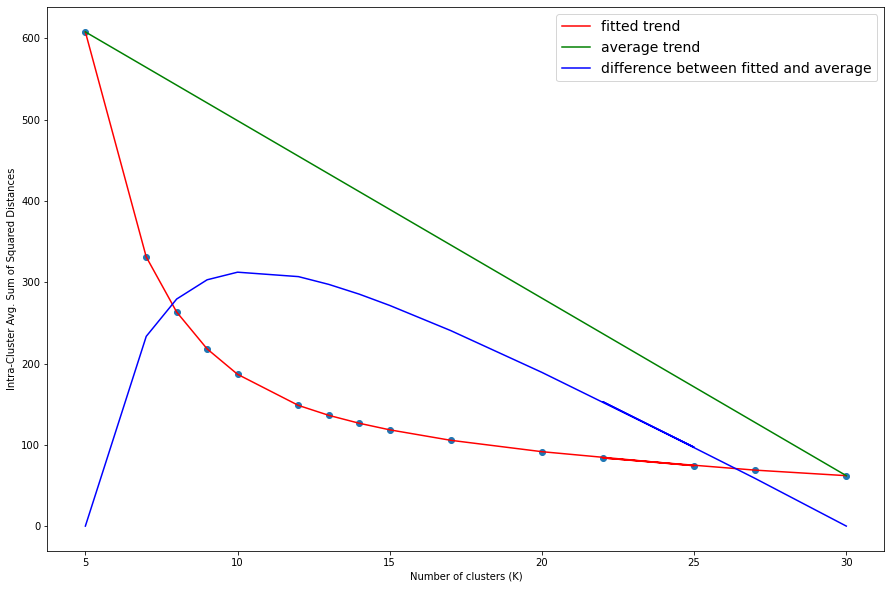

In [11]:
### Depending on your local runtime and RAM, you may need to split the dataset up for scoring.

# train_scores = score_inertia(training_set)

### Storing the scores locally

# np.save('train_scores.npy', train_scores)

### Loading the previously calculated scores

train_scores = np.load('./train_inertia_scores.npy')

### Plotting Initial results and commentary
train_best_k = elbow_inertia(train_scores)

#### 6.1.2 Elbow-Method with Inertia (Testing)

The optimal choice for K is:  10


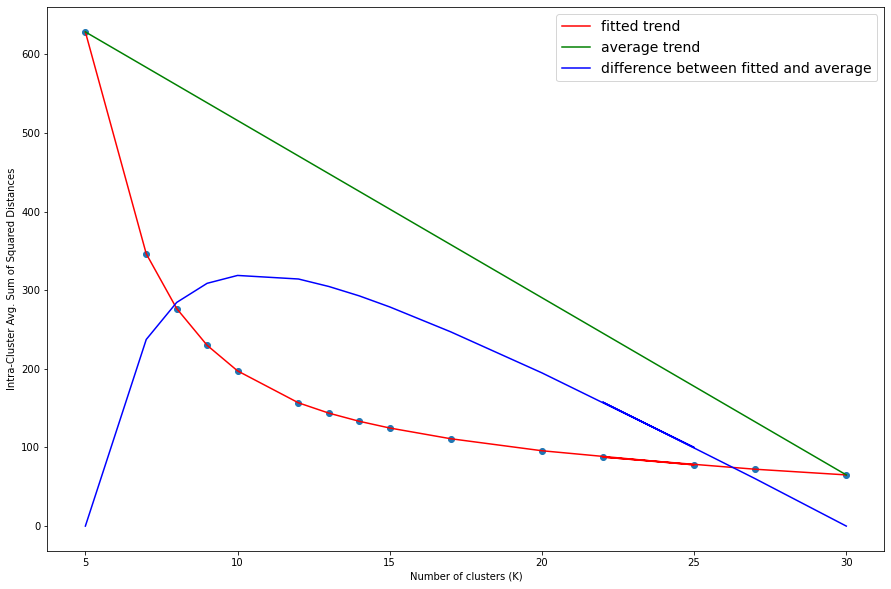

In [15]:
### Depending on your local runtime and RAM, you may need to split the dataset up for scoring.

# test_scores = score_inertia(test_set)

### Storing the scores locally

# np.save('test_scores.npy', test_scores)

### Loading the previously calculated scores

test_scores = np.load('./test_inertia_scores.npy')

### Plotting Test set results

test_best_k = elbow_inertia(test_scores)

#### 6.1.3 Elbow-Method with Inertia Resutls

In [16]:
print("The optimal cluster value K was the same for both training and test sets:", test_best_k == train_best_k)

The optimal cluster value K was the same for both training and test sets: True


Text(0, 0.5, 'Intra-Cluster Avg. Sum of Squared Distances')

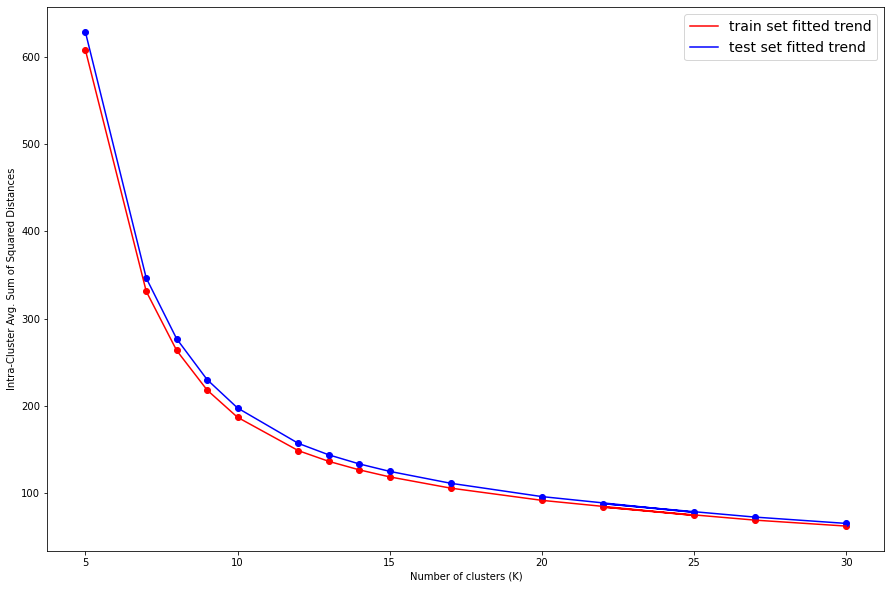

In [19]:
fig = plt.figure(figsize=(15,10))
n_clusters = [5, 7, 8, 9, 10, 12, 13, 14, 15, 17, 20, 25, 22, 27, 30]
# calculate and plot train model averages
train_model_avgs = [np.sum(train_scores[:, i])/train_scores.shape[0] for i in range(len(n_clusters))]
plt.scatter(n_clusters, train_model_avgs, c='r')
# fit and plot (z & p) a trendline for the train inertia
z_train = np.polyfit(n_clusters, train_model_avgs, 10)
p_train = np.poly1d(z_train)
plt.plot(n_clusters, p_train(n_clusters), 'r', label='train set fitted trend')

# calculate and plot test model averages
test_model_avgs = [np.sum(test_scores[:, i])/test_scores.shape[0] for i in range(len(n_clusters))]
plt.scatter(n_clusters, test_model_avgs, c='b')
# fit and plot (z & p) a trendline for the test inertia
z_test = np.polyfit(n_clusters, test_model_avgs, 10)
p_test = np.poly1d(z_test)
plt.plot(n_clusters, p_test(n_clusters), 'b', label='test set fitted trend')






plt.legend(loc='best', fontsize=14)
plt.xlabel('Number of clusters (K)')
plt.ylabel('Intra-Cluster Avg. Sum of Squared Distances')

If it wasn't clear from the two individual results of the elbow method with testing and training set, this recent plot highlights directly that the trends of each dataset are very similar. This means that the optimization of the K-Means model is not overfitting or underfitting the data.

#### 6.2.1 Elbow-Method with Explained Variance

The optimal choice for K is : 5


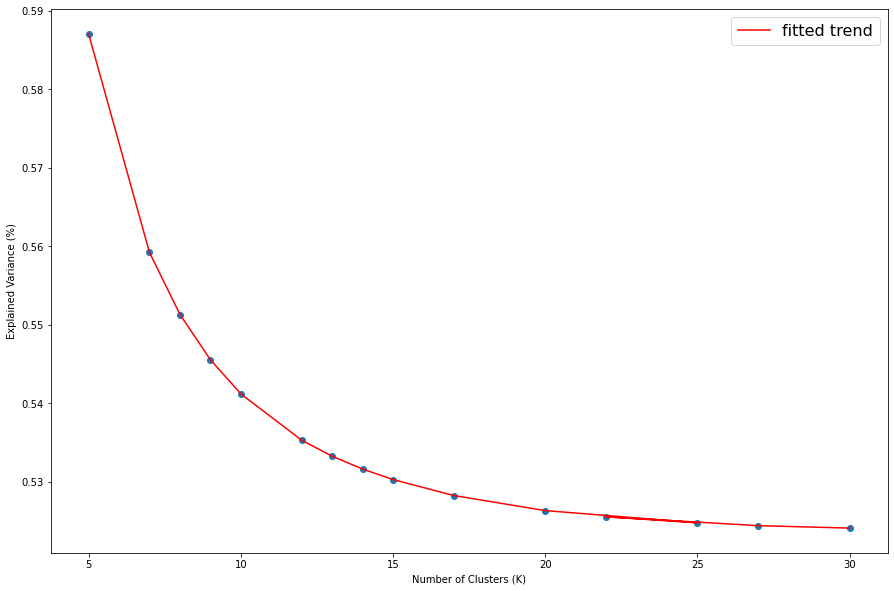

In [12]:
### Depending on your local runtime and RAM, you may need to split the dataset up for scoring.

# train_variances = score_var(train_set)
# test_variances = score_var(test_set)

### Storing the scores locally

# np.save('train_variances.npy', train_variances)
# np.save('test_variances.npy', test_variances)

### Loading the previously calculated scores

test_variances = np.load('./test_set_variance.npy')

### Plotting results
best_k_variance = elbow_variance(test_variances)

Unfortunately, the results of the elbow method using explained variance gave a different result for best K, as the best K in the explained variance is simply the highest value. However, the trend we see still reveals useful information. In 6.1, a mathematical interpretation (the blue line in the figures) was derived to alleviate vagueness in deciding the optimal K value. This interpretation led to a narrow decision for K=10, with K=12 being very close behind. However, with the plot above, we can confirm that K=10 is the optimal choice for this model and dataset, with a higher explained variance than any K values larger.

#### 6.3 Final Predictions

In [2]:
### Depending on your local runtime and RAM, you may need to split the dataset up for scoring.

#train_predictions, train_inerts = predict(training_set)
#test_predictions, test_inerts = predict(test_set)

### Storing the predictions locally

#np.save('train_predictions.npy', train_predictions)
#np.save('train_inerts.npy', train_inerts)
#np.save('test_predictions.npy', test_predictions)
#np.save('test_inerts.npy', test_inerts)

### Loading the previously calculated predictions and scores

train_predictions = np.load('./train_predictions.npy')
train_inerts = np.load('./train_inerts.npy')
test_predictions = np.load('./test_predictions.npy')
test_inerts = np.load('./test_inerts.npy')

### 7. Thresholding the results by inertia.

Training Set Mean, Median, Std. Dev. : 6.109805982633064 2.560145720373839 8.314930296937076
Testing Set Mean, Median, Std. Dev. : 11.750580882040706 8.74516687868163 10.59727447705041


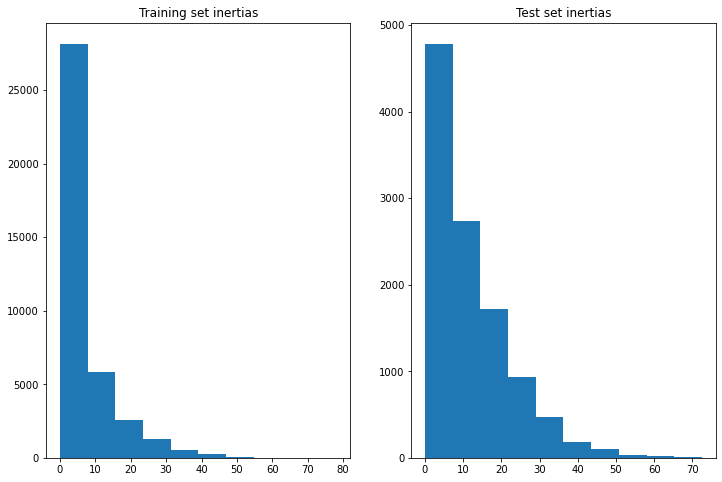

In [5]:
### Plotting the distribution and determining a statistical cutoff for thresholding images
### with relatively large inertias.

fig = plt.figure(figsize=(12,8))
fig.add_subplot(1, 2, 1)
plt.hist(train_inerts)
plt.title('Training set inertias')
fig.add_subplot(1, 2, 2)
plt.hist(test_inerts)
plt.title('Test set inertias')

# complete_inertias = np.concatenate((test_inerts, train_inerts))
print('Training Set Mean, Median, Std. Dev. :', np.mean(train_inerts), np.median(train_inerts), np.std(train_inerts))
print('Testing Set Mean, Median, Std. Dev. :', np.mean(test_inerts), np.median(test_inerts), np.std(test_inerts))

### If applicable

#print('Complete Set Mean, Median, Std. Dev. :', np.mean(complete_inertias), 
#      np.median(complete_inertias), np.std(complete_inertias))

In [7]:
### Thresholding images with an inertia 2 standard deviation above the median inertia.

# non_faults_train = np.where(train_inerts > )
# non_faults_test = np.where(test_inerts > )

### Nullifying these areas (Casting them to the background by assigning them 0)

#for image in non_faults_train:
#    train_predictions[image, :, 0] = np.zeros((10000))
#for image in non_faults_test:
#    test_predictions[image, :, 0] = np.zeros((10000))

### 8. Combining Predicted Fault Locations with FWI data
We are primarily looking for information from within predicted fault locations, but it is necessary to also retrieve
the velocity information from outside of predicted fault locations for leakage assessment (see Section 10 below)

In [14]:
### Creating three separate interpretable volumes - the testing, training, and combined volume.

test_results, test_results_nonfault = mask(FWI_patched[split1:split2, :, :], masks=test_predictions)

train_results, train_results_nonfault = mask(FWI_patched[split2:split3, :, :], masks=train_predictions)

results, results_nonfault = mask(FWI_patched[split1:split3, :, :], np.concatenate((test_predictions, train_predictions), axis=1))

### 9. Unpatching the dataset


#### 9.1 Determining the unpatched volume dimensions.
With some data being lost during patching, the code below demonstrates how to put the patches back to their original locations when using 100x100 pixel patches. 

In [8]:
### instantiating dimensions [# of images, Ilines, Xlines]

#Ilines = np.round(reflectivity.shape[0], -2)
#Xlines = np.round(reflectivity.shape[1], -2)

#complete_shape = [reflectivity.shape[2]-60, Ilines, Xlines]
#train_shape = [int(train_predictions.shape[1]/patch_num), Ilines, Xlines]
#test_shape = [int(test_predictions.shape[1]/patch_num), Ilines, Xlines]

### unpatching the result volumes to their original shape

#test_results = unpatch(test_results, image_size=test_shape)
#train_results = unpatch(train_results, image_size=train_shape)
#results = unpatch(results, image_size=complete_shape)

### save results
#np.save('./test_set_results.npy', test_results)
#np.save('./train_set_results.npy', train_results)
#np.save('./full_results.npy', results)

### load previously obtained results
test_results = np.load('./test_set_results.npy')
train_results = np.load('./train_set_results.npy')
results = np.load('./full_results.npy')

### 10. Fault Leakage Assessment

#### 10.1 Data Visualization
The visualization window created in the cell below must be closed before runnning any other operations within the notebook.

In [ ]:
explore3d(results)